In [20]:
from collections import namedtuple
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, fbeta_score, make_scorer

import presentation as p

data = pd.read_csv('data/creditcard/creditcard.csv').drop_duplicates()

X = data.drop(['Class', 'Time'], axis=1)
y = data['Class']

X_train, X_test, y_train, y_true = train_test_split(
    X, y,
    test_size=.8,
    stratify=y,
    random_state=404
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def simple_confusion_matrix(y_true, y_pred, target):
    sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, cmap=p.Colors.blues_c)
    plt.title(f'Confusion Matrix for Target "{target}"')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    sns.heatmap(data=confusion_matrix(y_true, y_pred), annot=True, cmap=p.Colors.purples_c)
    plt.title(f'Confusion Matrix for Target "{target}"')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

eval_result = namedtuple('HyperparameterTuningResult', ['model', 'accuracy', 'fbeta'])

def evaluate_model(model, X_test, y_true, beta, average):
    pred = model.predict(X_test)
    acc = accuracy_score(y_true, pred)
    fbeta = fbeta_score(y_true, pred, beta=beta, average=average)
    print('-- Training Results --')
    print(f'Best Parameters:\n{param_string}', end='')
    print(f'Best Score:\n\t{best_score:.6f}')
    print('\n-- Testing Results --')
    print(f'Accuracy    on Verification Data:\t{acc:.6f}')
    print(f'Fbeta scroe on Verification Data:\t{fbeta:.6f}\n')
    print(classification_report(y_true, pred))
    return eval_result(model, acc, fbeta)

--------------------------------------------------------------------------------

# Neural Network

In [109]:
metrics = tf.keras.metrics.FBetaScore(beta=100., threshold=.5, average='weighted')
nn_model = Sequential([
    Input(
        shape=(X_train.shape[1],),
        batch_size=128
    ),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    #Dense(16, activation='relu'),
    Dropout(.2),
    Dense(1, activation='sigmoid'),
])
nn_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[metrics, tf.keras.metrics.Accuracy()]
    #metrics=['accuracy']
)

In [110]:
history = nn_model.fit(
    X_train_scaled,
    y_train,
    epochs=10,
    validation_split=.15,
    verbose=2
)

Epoch 1/10
1508/1508 - 1s - 857us/step - accuracy: 1.4513e-04 - fbeta_score: 0.4938 - loss: 0.0143 - val_accuracy: 0.0000e+00 - val_fbeta_score: 0.7857 - val_loss: 0.0041
Epoch 2/10
1508/1508 - 1s - 475us/step - accuracy: 8.2931e-05 - fbeta_score: 0.7161 - loss: 0.0032 - val_accuracy: 0.0000e+00 - val_fbeta_score: 0.6429 - val_loss: 0.0041
Epoch 3/10
1508/1508 - 1s - 527us/step - accuracy: 1.0366e-04 - fbeta_score: 0.7408 - loss: 0.0028 - val_accuracy: 0.0000e+00 - val_fbeta_score: 0.7857 - val_loss: 0.0043
Epoch 4/10
1508/1508 - 1s - 469us/step - accuracy: 8.2931e-05 - fbeta_score: 0.7901 - loss: 0.0023 - val_accuracy: 1.1748e-04 - val_fbeta_score: 0.7857 - val_loss: 0.0046
Epoch 5/10
1508/1508 - 1s - 467us/step - accuracy: 1.2440e-04 - fbeta_score: 0.7778 - loss: 0.0024 - val_accuracy: 0.0000e+00 - val_fbeta_score: 0.7857 - val_loss: 0.0050
Epoch 6/10
1508/1508 - 1s - 476us/step - accuracy: 2.9026e-04 - fbeta_score: 0.8025 - loss: 0.0020 - val_accuracy: 2.3496e-04 - val_fbeta_score: 

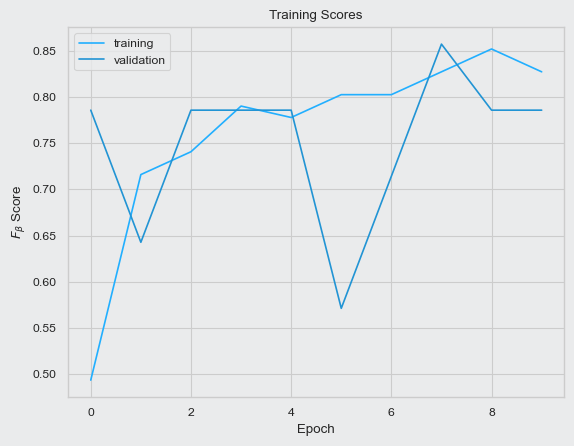

In [111]:
# Visualize Learning History

score = 'fbeta_score'
sns.lineplot(history.history[score], label='training')
sns.lineplot(history.history[f'val_{score}'], label='validation')
plt.title('Training Scores')
plt.xlabel('Epoch')
plt.ylabel(r'$F_\beta$ Score')
plt.show()

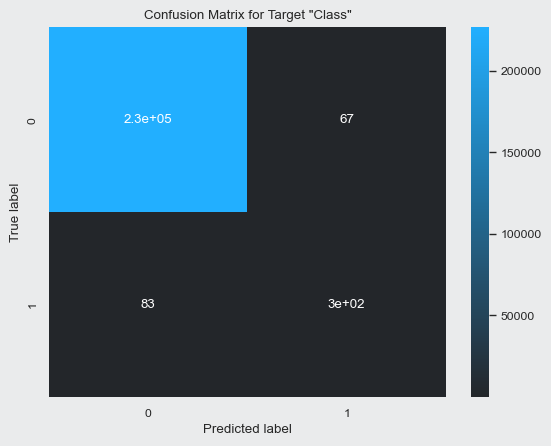

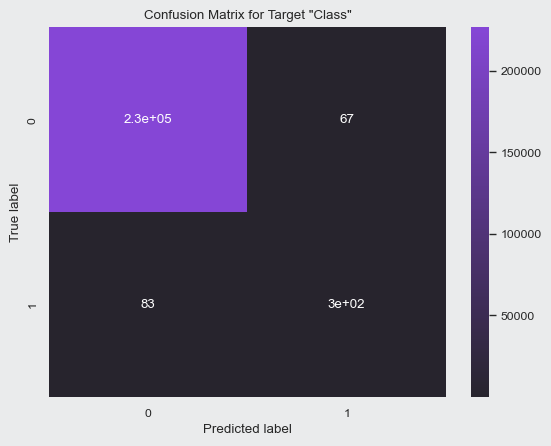

In [112]:
# Evaluation

y_pred = nn_model.predict(X_test_scaled, verbose=0)
y_pred = (y_pred > .5).astype(int).flatten()
simple_confusion_matrix(y_true, y_pred, 'Class')

In [113]:
from sklearn.metrics import confusion_matrix
total_frauds = y_true.value_counts().iloc[1]
confusion = confusion_matrix(y_true, y_pred)
false_negatives = confusion[1, 0]
print(f'False negatives: {false_negatives} ({100 * false_negatives / total_frauds:.3f}% out of {total_frauds} frauds, {100 * false_negatives / len(y_true):.3f}% overall)\n')

False negatives: 83 (21.958% out of 378 frauds, 0.037% overall)



In [114]:
nn_model.evaluate(X_test_scaled, y_true)

7094/7094 ━━━━━━━━━━━━━━━━━━━━ 2s 333us/step - accuracy: 0.0011 - fbeta_score: 0.7725 - loss: 0.0052


[0.005826843902468681, 0.7804266214370728, 0.0011146307224407792]

In [115]:
nn_model.get_metrics_result()

{'accuracy': 0.0011146307224407792,
 'fbeta_score': 0.7804266214370728,
 'loss': 0.005826843902468681}

In [116]:
history = nn_model.fit(
    X_train_scaled,
    y_train,
    epochs=65,
    validation_split=.15,
    verbose=2
)

Epoch 1/65
1508/1508 - 1s - 506us/step - accuracy: 0.0012 - fbeta_score: 0.8765 - loss: 0.0010 - val_accuracy: 0.0015 - val_fbeta_score: 0.7857 - val_loss: 0.0082
Epoch 2/65
1508/1508 - 1s - 489us/step - accuracy: 0.0012 - fbeta_score: 0.8519 - loss: 0.0011 - val_accuracy: 0.0011 - val_fbeta_score: 0.7857 - val_loss: 0.0073
Epoch 3/65
1508/1508 - 1s - 482us/step - accuracy: 0.0019 - fbeta_score: 0.9012 - loss: 9.6698e-04 - val_accuracy: 0.0027 - val_fbeta_score: 0.7143 - val_loss: 0.0089
Epoch 4/65
1508/1508 - 1s - 485us/step - accuracy: 0.0024 - fbeta_score: 0.8642 - loss: 0.0011 - val_accuracy: 0.0029 - val_fbeta_score: 0.6429 - val_loss: 0.0078
Epoch 5/65
1508/1508 - 1s - 485us/step - accuracy: 0.0031 - fbeta_score: 0.8765 - loss: 8.1089e-04 - val_accuracy: 0.0034 - val_fbeta_score: 0.7857 - val_loss: 0.0086
Epoch 6/65
1508/1508 - 1s - 501us/step - accuracy: 0.0040 - fbeta_score: 0.9012 - loss: 6.7757e-04 - val_accuracy: 0.0029 - val_fbeta_score: 0.8571 - val_loss: 0.0113
Epoch 7/65

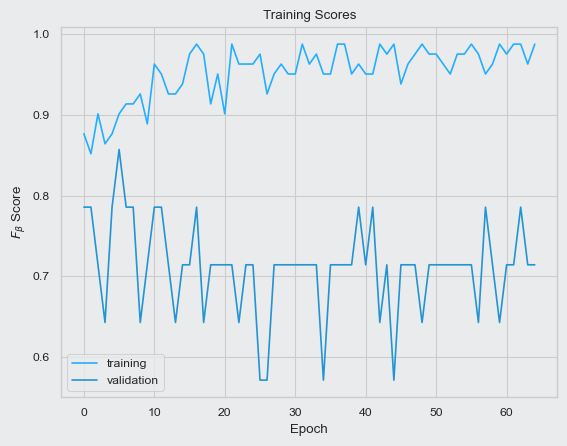

In [117]:
# Visualize Learning History

score = 'fbeta_score'
sns.lineplot(history.history[score], label='training')
sns.lineplot(history.history[f'val_{score}'], label='validation')
plt.title('Training Scores')
plt.xlabel('Epoch')
plt.ylabel(r'$F_\beta$ Score')
plt.show()

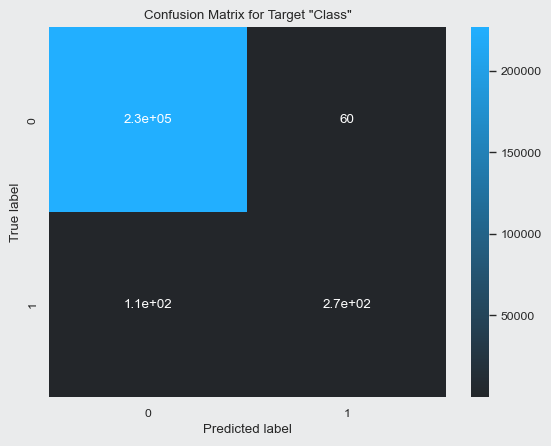

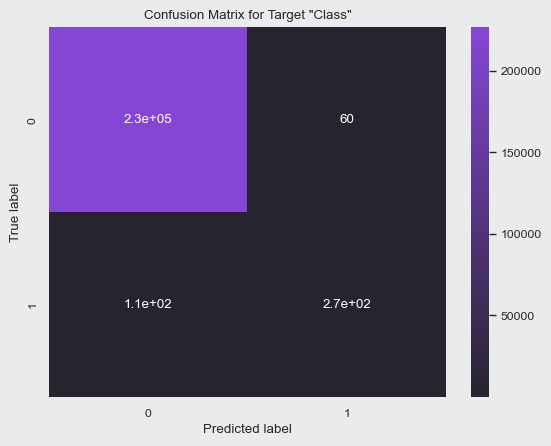

In [118]:
# Evaluation

y_pred = nn_model.predict(X_test_scaled, verbose=0)
y_pred = (y_pred > .5).astype(int).flatten()
simple_confusion_matrix(y_true, y_pred, 'Class')

In [119]:
total_frauds = y_true.value_counts().iloc[1]
confusion = confusion_matrix(y_true, y_pred)
false_negatives = confusion[1, 0]
print(f'False negatives: {false_negatives} ({100 * false_negatives / total_frauds:.3f}% out of {total_frauds} frauds, {100 * false_negatives / len(y_true):.3f}% overall)\n')

False negatives: 110 (29.101% out of 378 frauds, 0.048% overall)



In [120]:
nn_model.evaluate(X_test_scaled, y_true)

7094/7094 ━━━━━━━━━━━━━━━━━━━━ 2s 280us/step - accuracy: 0.2105 - fbeta_score: 0.6988 - loss: 0.0171


[0.01760399341583252, 0.7090040445327759, 0.20977967977523804]

In [121]:
nn_model.get_metrics_result()

{'accuracy': 0.20977967977523804,
 'fbeta_score': 0.7090040445327759,
 'loss': 0.01760399341583252}

In [122]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.9992510386331895

In [123]:
from sklearn.metrics import fbeta_score
fbeta_score(y_true, y_pred, beta=100., average='binary')

0.7090040864178981

--------------------------------------------------------------------------------

Save both models for re-use or adjustments.

In [124]:
nn_model.save('data/creditcard-nn.keras')